<a href="https://colab.research.google.com/github/nontivillu/nontivillu/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [5]:
# /content/sample_data/Tweets.json
df= pd.read_json("/content/sample_data/Tweets.json")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,None,NaN,Virgin America,None,cairdin,None,0,@VirginAmerica What @dhepburn said.,None,2015-02-24 11:35:52 -0800,None,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,None,0.0000,Virgin America,None,jnardino,None,0,@VirginAmerica plus you've added commercials t...,None,2015-02-24 11:15:59 -0800,None,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,None,NaN,Virgin America,None,yvonnalynn,None,0,@VirginAmerica I didn't today... Must mean I n...,None,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,None,jnardino,None,0,@VirginAmerica it's really aggressive to blast...,None,2015-02-24 11:15:36 -0800,None,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,None,jnardino,None,0,@VirginAmerica and it's a really big bad thing...,None,2015-02-24 11:14:45 -0800,None,Pacific Time (US & Canada)


Data Preprocessing
The first step should be to check the shape of the dataframe and then check the number of null values in each column.

In this way we can get an idea of the redundant columns in the data frame depending on which columns have the highest number of null values.

In [6]:
print("Shape of the dataframe is",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [7]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


,0
tweet_id,0.00
airline_sentiment,0.00
airline_sentiment_confidence,0.00
negativereason,37.31
negativereason_confidence,28.13
airline,0.00
airline_sentiment_gold,99.73
name,0.00
negativereason_gold,99.78
retweet_count,0.00


tweet_coord , airline_sentiment_gold, negativereason_gold have more than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.

In [8]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,None,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,None,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,None,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,None,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,None,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,None,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,None,Pacific Time (US & Canada)


Airline sentiments for each airline¶
Firstly lets calculate the total number of tweets for each airline
Then, we are going to get the barplots for each airline with respect to sentiments of tweets (positive,negative or neutral).
This will give us a clearer idea about the airline sentiments , airlines relationship.


Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


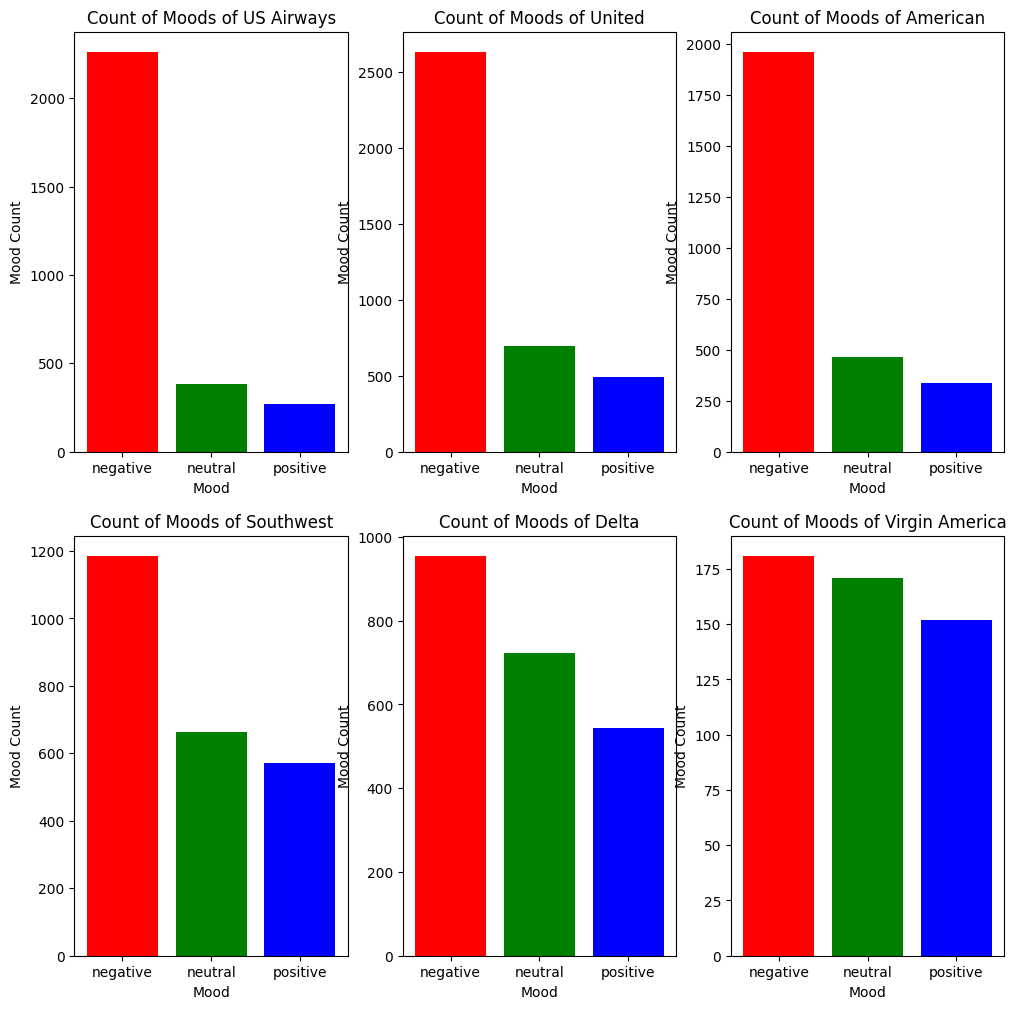

In [9]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

Most used words in Positive and Negative tweets¶

In [10]:
from wordcloud import WordCloud,STOPWORDS

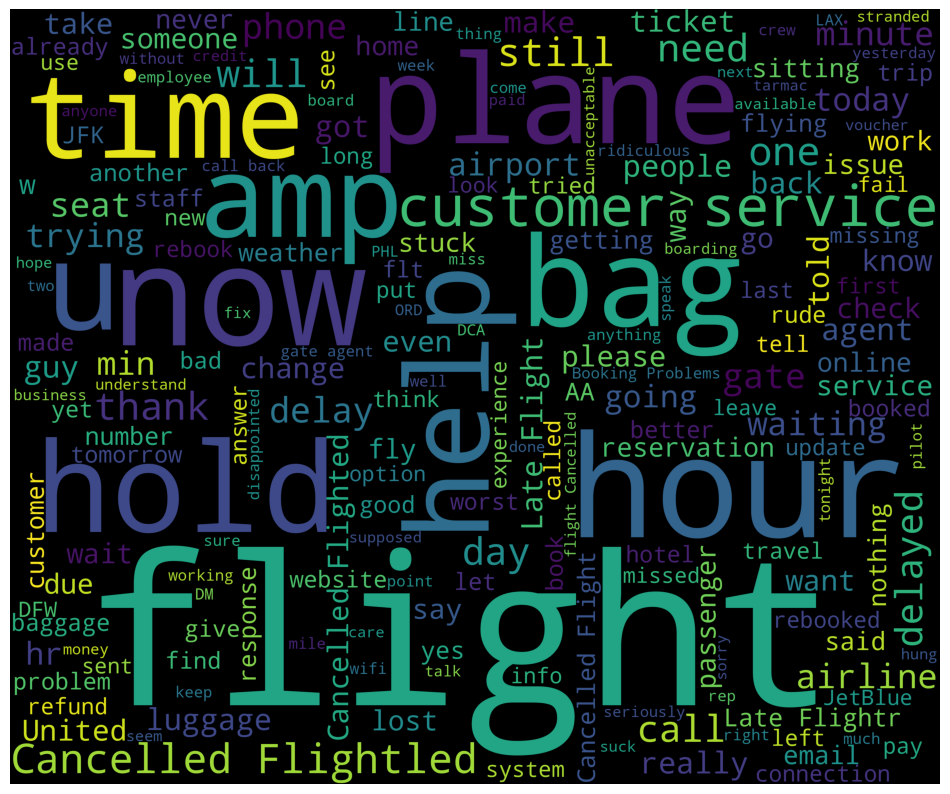

In [11]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

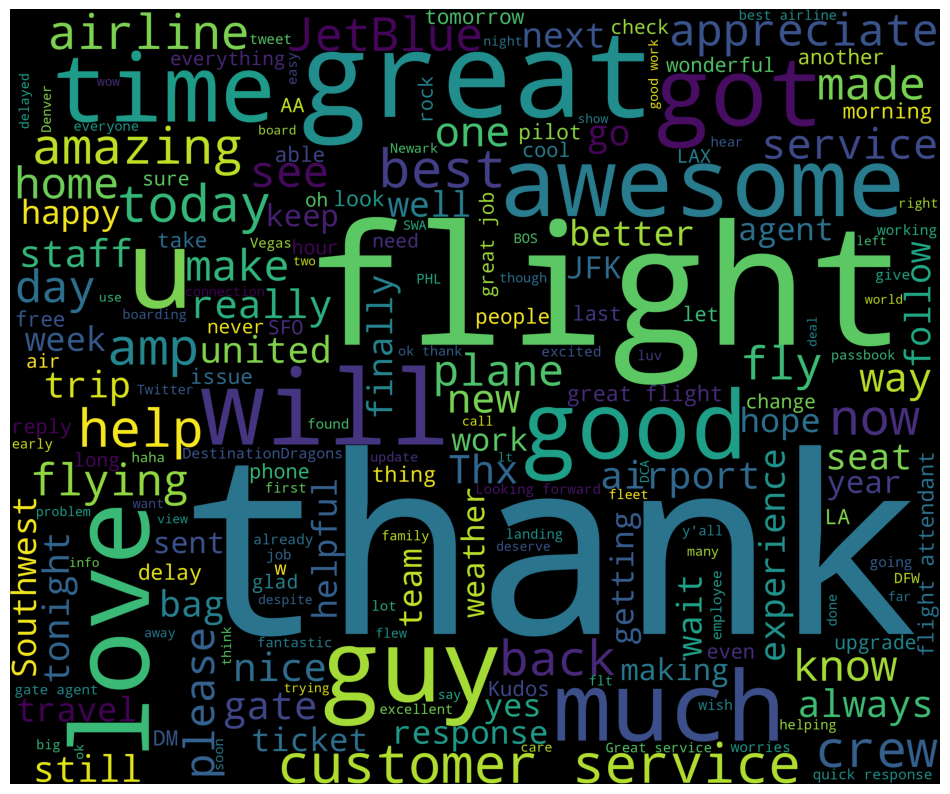

In [12]:
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [13]:
# Calculate highest frequency words in positive tweets
def freq(str):

    # break the string into list of words
    str = str.split()
    str2 = []

    # loop till string values present in list str
    for i in str:

        # checking for the duplicacy
        if i not in str2:

            # insert value in str2
            str2.append(i)

    for i in range(0, len(str2)):
        if(str.count(str2[i])>50):
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))

print(freq(cleaned_word))

Frequency of to is : 923
Frequency of the is : 924
Frequency of time is : 59
Frequency of I is : 574
Frequency of fly is : 54
Frequency of this is : 143
Frequency of :) is : 96
Frequency of it is : 166
Frequency of was is : 226
Frequency of and is : 416
Frequency of an is : 74
Frequency of good is : 75
Frequency of so is : 163
Frequency of much is : 54
Frequency of is is : 219
Frequency of a is : 501
Frequency of great is : 144
Frequency of my is : 320
Frequency of &amp; is : 77
Frequency of on is : 327
Frequency of I'm is : 67
Frequency of flying is : 59
Frequency of your is : 212
Frequency of all is : 92
Frequency of from is : 124
Frequency of Thanks! is : 69
Frequency of for is : 658
Frequency of flight is : 263
Frequency of but is : 91
Frequency of you is : 509
Frequency of would is : 56
Frequency of be is : 135
Frequency of with is : 195
Frequency of you. is : 77
Frequency of love is : 85
Frequency of You is : 62
Frequency of are is : 120
Frequency of of is : 236
Frequency of that

In [ ]:
#get the number of negative reasons
df['negativereason'].nunique()
print(df.value_counts('negativereason'))


NR_Count=dict(df['negativereason'].value_counts(sort=False))
print(NR_Count)


In [36]:

def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(df['negativereason'].value_counts(sort=False))
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'None']
    #Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame=pd.DataFrame(Unique_reason, columns=['Reasons'])
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def given_reason(Airline):
    print(Airline)
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)



ALL
US Airways
United
American
Southwest
Delta
Virgin America


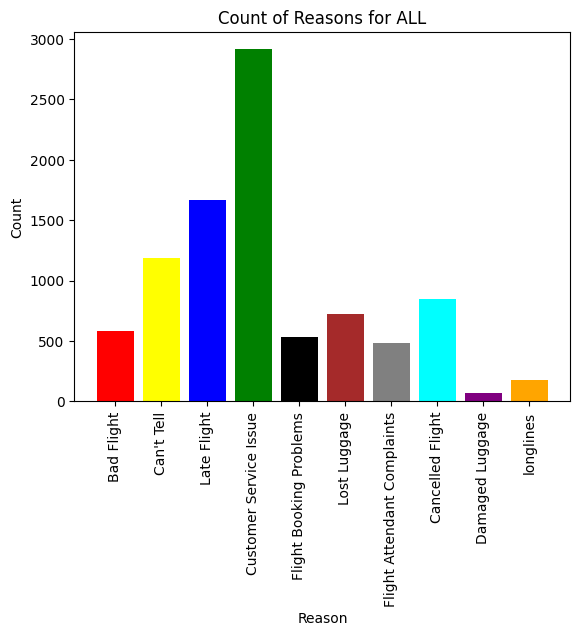

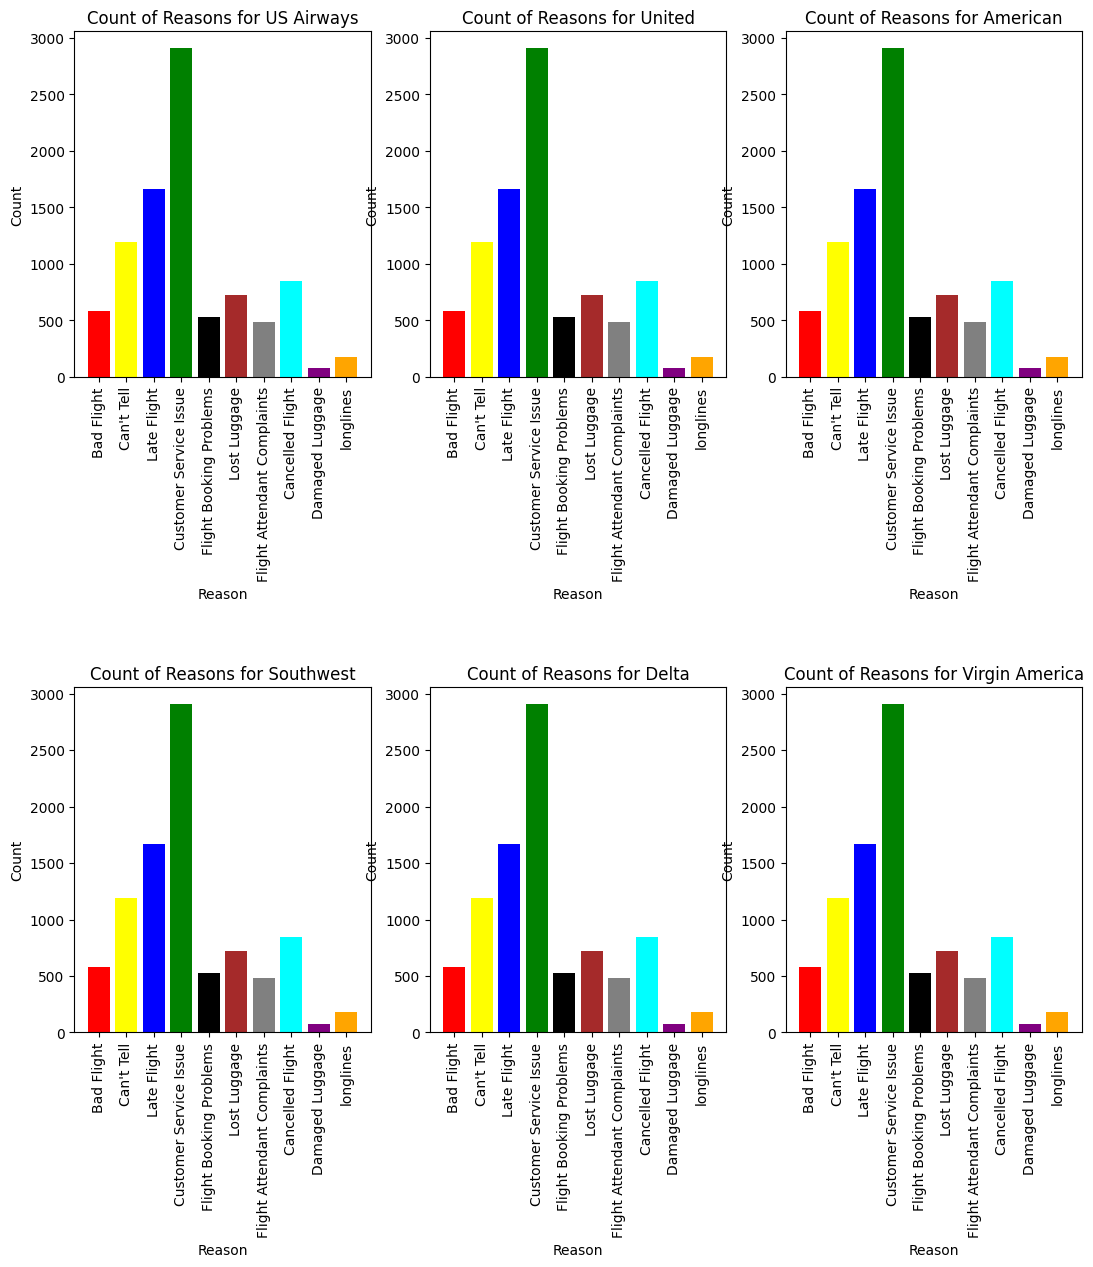

In [37]:
given_reason('ALL')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    given_reason(i)


In [38]:
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

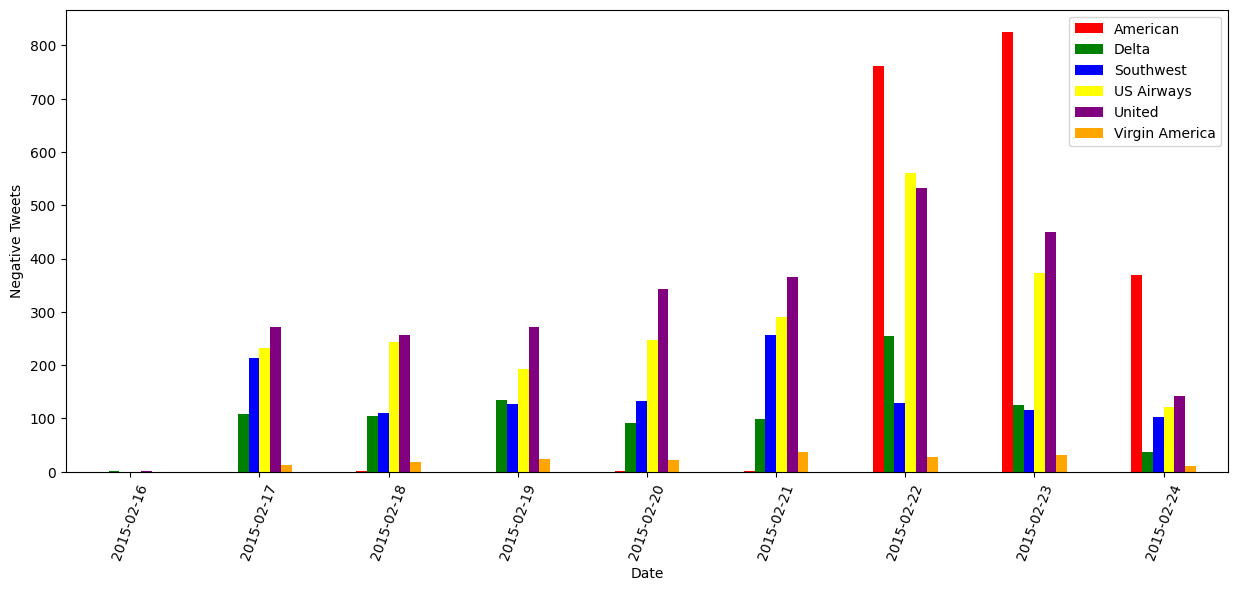

In [39]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

In [46]:
import nltk
nltk.download('stopwords')
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

In [48]:
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [49]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [51]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

Accuracy of DecisionTreeClassifieris 0.6847677595628415
              precision    recall  f1-score   support

    negative       0.79      0.80      0.80      1869
     neutral       0.43      0.40      0.41       613
    positive       0.57      0.59      0.58       446

    accuracy                           0.68      2928
   macro avg       0.60      0.60      0.60      2928
weighted avg       0.68      0.68      0.68      2928



<Figure size 640x480 with 0 Axes>

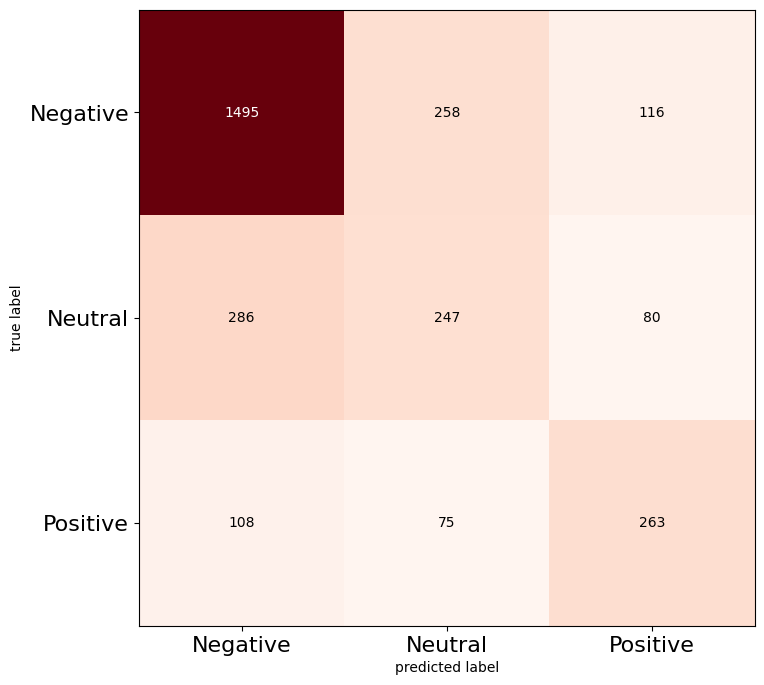

Accuracy of RandomForestClassifieris 0.7704918032786885
              precision    recall  f1-score   support

    negative       0.91      0.82      0.86      2109
     neutral       0.45      0.58      0.51       452
    positive       0.59      0.74      0.66       367

    accuracy                           0.77      2928
   macro avg       0.65      0.71      0.68      2928
weighted avg       0.80      0.77      0.78      2928



<Figure size 640x480 with 0 Axes>

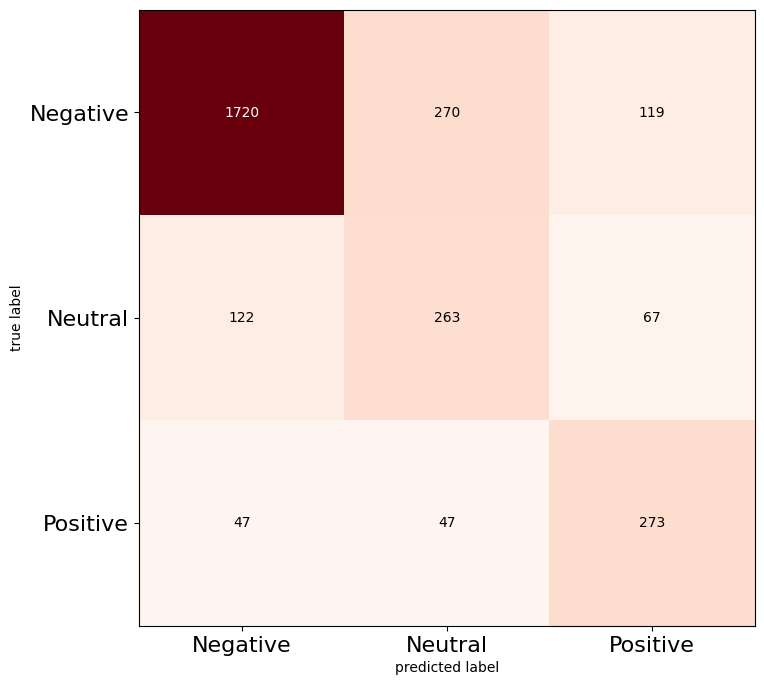

In [54]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['airline_sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['airline_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
    print(classification_report(pred,test['airline_sentiment']))
    cm=confusion_matrix(pred , test['airline_sentiment'])
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
    plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.show()